In [1]:
from fantasy_machine import update_data, import_data
from fantasy_machine import config
from fantasy_machine import stats
from fantasy_machine import model

import pandas as pd
import sqlite3

import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
bullpen_dc = {"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.depthchart_table)}},"AND":{"position":{"=":"'BULLPEN'"}}}
abr = import_data.get_data(db=config.id_mapping_db, 
                    table=config.team_abr_table)                 # team abr table
lineups = import_data.get_data(db=config.players_db_path,
                        table=config.lineups_table,
                        condition_dict={"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.lineups_table)}}})              # lineup table
player_map = import_data.get_data(db=config.id_mapping_db,
                           table=config.player_map_table,
                           cols=import_data.player_id_cols)             # playerid table
lineups_plus = lineups.merge(player_map,left_on=['player_id'],
                             right_on=['rotowire_id'],how='left')
dc = import_data.get_data(db=config.players_db_path,
                   table=config.depthchart_table,
                   condition_dict=bullpen_dc)                    # Bullpen table
bp_ids = dc.merge(player_map,left_on=['player_id'],
                 right_on=['mlb_id'],how='left')

event = import_data.get_data(db=config.mlb_db_path, cols=['gameid','batter','pitcher','eventtype','rbionplay',
                                                         'firstdest','firstrunner','seconddest','secondrunner',
                                                          'thirddest','thirdrunner','sbfirst','sbsecond','sbthird',
                                                          'vteam','battingteam','shflag','sfflag','abflag','outsonplay'],
                     table=config.mlb_event_table) # Event Data
event['date'] = pd.to_datetime(event['gameid'].apply(lambda x: 
                                                     str(x[3:7])+'-'+x[7:9]+'-'+x[9:11]))

event['hteam'] = event['gameid'].apply(lambda x: str(x[:3]))

calc = stats.baseball_stats.metric_calculator(data=event)

# try:
#     batter_base = pd.read_pickle('batter_base_full.pickle')
# except:

def correct_bool_cols(event):
    for bool_column in ['abflag','sfflag','shflag']:
        event[bool_column] = event[bool_column].replace('T',True).replace('F',False)
    return event
event = correct_bool_cols(event)
print('running...')
batter_base = calc.calculate_v2(df=event,#[event['date'] > '2010-01-01'],
                                groupby=['batter','date','pitcher','battingteam','vteam','hteam'], 
                                position='batter',
                                metric='base')
print('Pulled & Saving...')
batter_base.to_pickle('batter_base_full.pickle')

running...
Pulled & Saving...


In [5]:
con = sqlite3.connect(config.mlb_db_path)
batter_base2 = pd.read_sql(con=con,sql="select * from {}".format('player_base'))

In [9]:
batter_base.to_sql(con=con,if_exists='replace',name='player_base')

In [10]:
batter_base['season'] = pd.to_datetime(batter_base['date']).apply(lambda x: x.year)

In [17]:
%timeit -n4 event.groupby('batter').agg({'eventtype':calc.fs._1b})

4.22 s ± 452 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [18]:
%timeit -n4 event.groupby('batter')['eventtype'].agg({'eventtype':calc.fs._1b})

4.42 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [19]:
%timeit -n4 event.groupby('batter')['eventtype'].transform(calc.fs._1b)

7.07 s ± 735 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [20]:
%timeit -n4 event.groupby('batter')['eventtype'].apply(calc.fs._1b)

5.49 s ± 896 ms per loop (mean ± std. dev. of 7 runs, 4 loops each)


In [27]:
%%prun
calc.calculate_v2(df=event[event['date'] > '2018-08-01'],
                  groupby=['batter','date','pitcher','battingteam','vteam','hteam'],
                  position='batter',
                  metric='base')

# New Base Method

In [41]:
def correct_bool_cols():
    for bool_column in ['abflag','sfflag','shflag']:
        event[bool_column] = event[bool_column].replace('T',True).replace('F',False)
correct_bool_cols()

In [46]:
groupby = ['batter','date','pitcher','battingteam','vteam','hteam']

event_col_conversion = {
    3:'_k',
    14:'_bb',
    15:'_ibb',
    16:'_hbp',
    20:'_1b',
    21:'_2b',
    22:'_3b',
    23:'_hr'}
## Create calculate dataframes
_event = event.groupby(groupby + ['eventtype'])['gameid'].count().unstack(level=-1)
b_event = event[groupby + ['abflag','sfflag','shflag','rbionplay']].groupby(groupby).sum()
## Rename columns
_event = _event[list(event_col_conversion.keys())].rename(columns=event_col_conversion)
b_event.rename(columns={'abflag':'_ab',
                        'shflag':'_sh',
                        'sfflag':'_sf',
                        'rbionplay':'_rbi'}, inplace=True)
## Join tables
batter_base = _event.join(b_event)
batter_base.fillna(0)

In [3]:
f_df = calc.fs.get_batter_scoring_v2(df=batter_base.reset_index(),
                                     groupby=list(batter_base.index.names),
                                     position='batter',
                                     work_columns=True)

In [4]:
f_df.to_pickle("batter_base_fs_full.pickle")

In [ ]:
try:
    f_df = calc.fs.get_batter_scoring_v2(df=X.reset_index(),
                                     groupby=['batter','season'],
                                     position='batter',
                                     work_columns=True)
except:
    calc.fs.b_scoring_matrix=calc.fs.b_scoring_matrix.set_index(calc.fs.b_scoring_matrix.columns.tolist()[0])
    f_df = calc.fs.get_batter_scoring_v2(df=X.reset_index(),
                                     groupby=['batter','season'],
                                     position='batter',
                                     work_columns=True)

f_df2 = calc.fs.get_batter_scoring_v2(df=batter_base.reset_index(),
                                     groupby=['batter','date','season'],
                                     position='batter',
                                     work_columns=True)
f_std = f_df2.reset_index()[['batter','season','f_score']].groupby(['batter','season']).std().rename(columns={'f_score':'f_score STD'})

# Cluster Model

In [292]:
cluster_color = {
    0:'#001f3f',
    1:'#0074D9',
    2:'#7FDBFF',
    3:'#39CCCC',
    4:'#3D9970',
    5:'#2ECC40',
    6:'#01FF70',
    7:'#FFDC00',
    8:'#FF851B',
    9:'#FF4136',
    10:'#85144b',
    11:'#F012BE',
    12:'#B10DC9',
    13:'#111111',
    14:'#AAAAAA',
    15:'#DDDDDD',
    16:'#001f3f',
    17:'#0074D9',
    18:'#7FDBFF',
    19:'#39CCCC',
    20:'#3D9970',
    21:'#2ECC40',
    22:'#01FF70',}


In [295]:
def run_cluster(X, clusters):
    # Model itself
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X.as_matrix())
    kmeans.labels_
    print(pd.DataFrame(kmeans.cluster_centers_, columns=X.columns))
    X['cluster'] = kmeans.labels_
    # Colors for later to map with
    # Get extra fantasy data and score the existing X dataframe
    
    try:
        f_df = calc.fs.get_batter_scoring_v2(df=X.reset_index(),
                                         groupby=['batter','season'],
                                         position='batter',
                                         work_columns=True)
    except:
        calc.fs.b_scoring_matrix=calc.fs.b_scoring_matrix.set_index(
            calc.fs.b_scoring_matrix.columns.tolist()[0])
        f_df = calc.fs.get_batter_scoring_v2(df=X.reset_index(),
                                         groupby=['batter','season'],
                                         position='batter',
                                         work_columns=True)

    f_df2 = calc.fs.get_batter_scoring_v2(df=batter_base.reset_index(),
                                         groupby=['batter','date','season'],
                                         position='batter',
                                         work_columns=True)
    f_std = f_df2.reset_index()[['batter','season','f_score']].groupby(
        ['batter','season']).std().rename(columns={'f_score':'f_score STD'})
    
    # Combine all the parts 
    ## Cluster ranking
    ## real names
    ## fantasy scoring standard deviation
    f_df_ = f_df.reset_index()
    final = f_df_.merge(player_map[['retro_id','mlb_name']], 
                         left_on=['batter'], 
                         right_on=['retro_id'],
                         how='left').merge(f_std.reset_index(), 
                                           on=['batter','season'], 
                                           how='left')
    final['f_score mean'] = final['f_score']/final['_ab']

    # For mapping
    final['cluster_color'] = final['cluster'].map(cluster_color)
    
    return final

# Run Model

In [370]:
X = batter_base.groupby(['batter','season']).sum()

In [371]:
final = run_cluster(X, clusters=10)

   battingteam         _1b        _2b       _3b        _hr      _hbp  \
0     2.714467    0.851523   0.190673  0.017766   0.064404  0.046637   
1   153.970750   88.076782  26.261426  2.813528  15.314442  4.855576   
2    82.940952   40.885714  11.977143  1.320000   6.546667  2.617143   
3   176.822102  117.355795  33.161725  3.474394  17.312668  5.059299   
4   105.685824   55.618774  16.356322  1.752874   9.206897  3.611111   
5    39.270769   17.546154   5.035385  0.560000   2.461538  1.132308   
6    18.074290    6.869629   1.671522  0.163146   0.682447  0.338674   
7   131.330206   68.870544  21.073171  2.061914  13.574109  4.410882   
8    61.879865   29.093063   8.467005  0.984772   4.343486  1.791878   
9   178.211429   88.474286  30.754286  2.871429  27.342857  6.208571   

         _bb      _ibb          _k         _ab       _sf       _sh       _rbi  
0   0.410533  0.012373    2.976206    7.741751  0.024429  0.472398   0.440038  
1  40.751371  3.385740   97.592322  496.870201 

KeyError: 'FD'

In [348]:
# f_df[['cluster','f_score']].groupby('cluster').agg(
#     {'f_score':['mean','median','std']})['f_score'].sort_values('mean')

In [349]:
final[final['batter']=='troum001'][['season','f_score','cluster']]

,season,f_score,cluster
7888,2011,233.0,5
7889,2012,1442.5,9
7890,2013,1650.5,9
7891,2014,1663.5,9
7892,2015,1596.0,9
7893,2016,1601.0,9
7894,2017,1269.0,7
7895,2018,1485.5,1


In [350]:
cluster_label = final.groupby('cluster').mean()

In [351]:
cluster_label = cluster_label.replace(np.inf,0)

<IPython.core.display.Javascript object>


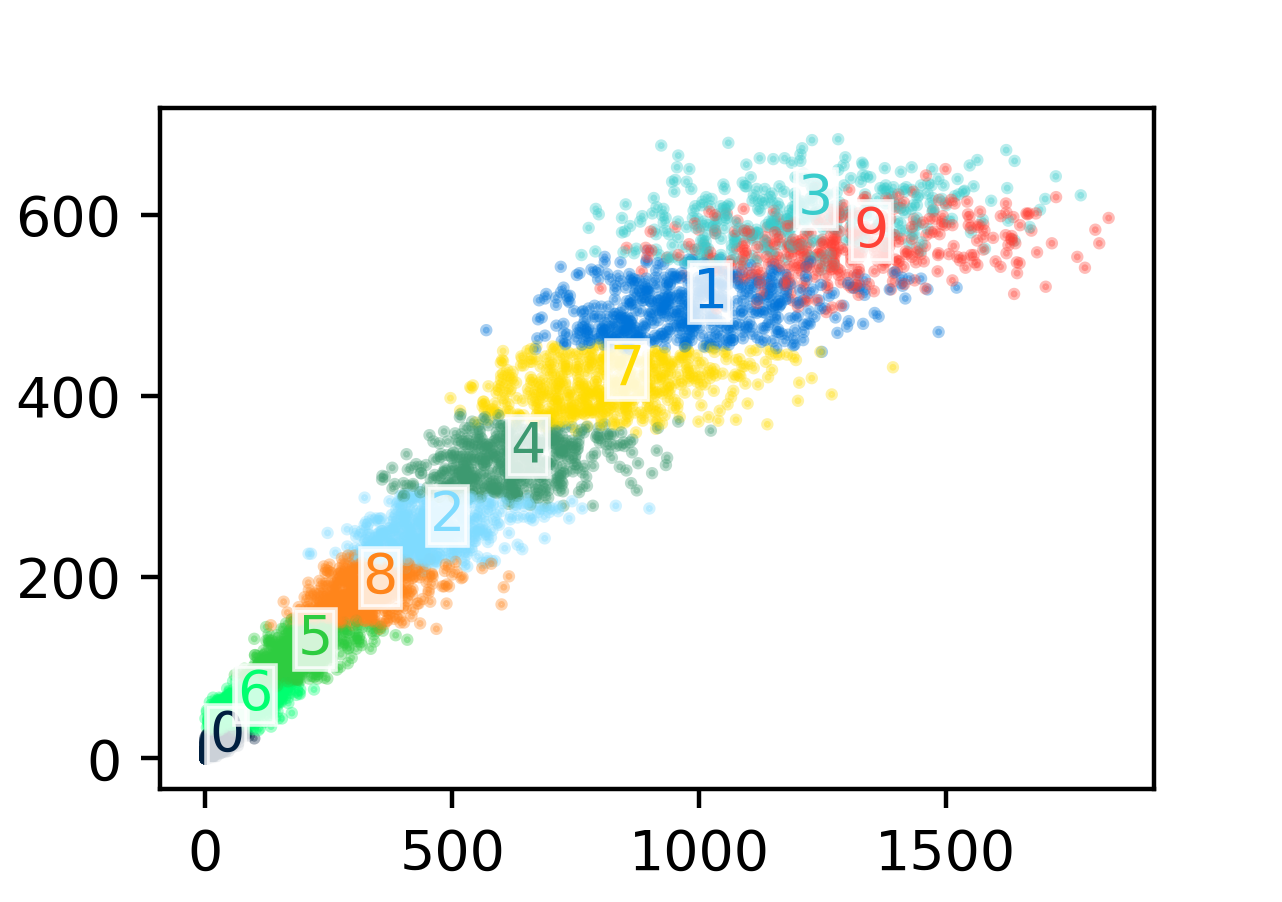

Text(0,0.5,'_ab')

In [352]:
plot_x = 'f_score'
plot_y = '_ab'
plot_y2 = ''

fig, ax = plt.subplots(dpi=200)
ax.scatter(final[plot_x], 
           final[plot_y], 
           color=final['cluster_color'], 
           alpha=.35, 
           s=1.5)
for clu in cluster_label.index.tolist():
    ax.text(x=cluster_label.loc[clu][plot_x],
            y=cluster_label.loc[clu][plot_y]+1,
            s=clu, color =cluster_color[clu],
           bbox=dict(facecolor='white',
                     pad=.4,
                     alpha=.8,
                     edgecolor='white'))
ax.set_xlabel(plot_x)
ax.set_ylabel(plot_y)

In [337]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


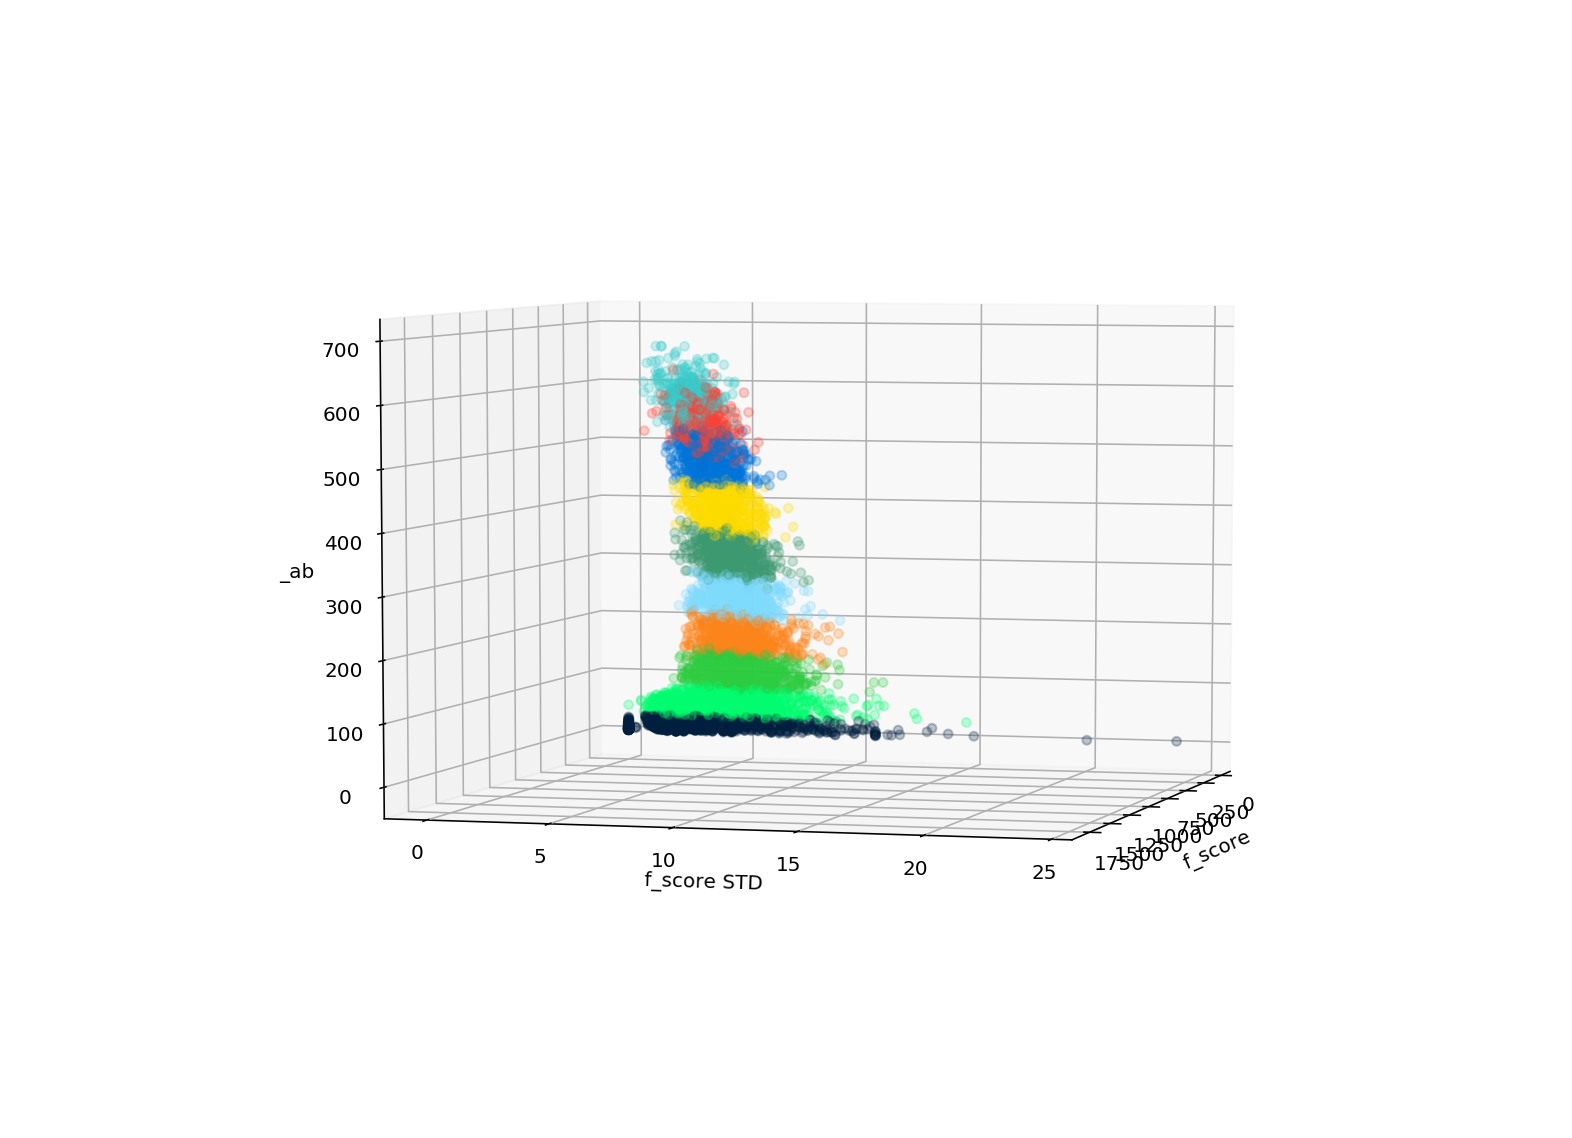

Text(0.5,0,'_ab')

In [353]:
plot_x = 'f_score'
plot_y = 'f_score STD'
plot_y2 = '_ab'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final[plot_x],
           final[plot_y],
           final[plot_y2],
           c=final['cluster_color'],
           alpha=.25)

ax.set_xlabel(plot_x)
ax.set_ylabel(plot_y)
ax.set_zlabel(plot_y2)

In [354]:
def get_cluster_list(df, cluster, return_name):
    if type(cluster) == int:
        cluster = [cluster]
    cluster_batters = df[df['cluster'].isin(cluster)][return_name].dropna().tolist()
    batter_years = df[df['season'] == 2018][return_name].dropna().tolist()
    return list(set(cluster_batters) & set(batter_years))

In [357]:
# get_cluster_list(final, cluster=[3], return_name='mlb_name')

## Just Batter Season Run

In [378]:
X = f_df.join(f_std)[['f_score','f_score STD','_ab']].dropna()

In [381]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X.as_matrix())
kmeans.labels_
print(pd.DataFrame(kmeans.cluster_centers_, columns=X.columns))
X['cluster'] = kmeans.labels_
X['cluster_color'] = X['cluster'].map(cluster_color)

       f_score  f_score STD         _ab   cluster
0  1228.795402     8.321943  559.726437  0.016092
1    85.663223     5.021560   61.425620  1.030992
2   660.889925     7.080670  353.533582  2.022388
3   486.395948     6.698059  270.497238  7.898711
4  1020.453488     7.642894  515.431290  6.991543
5  1494.750000     9.258054  584.669643  4.000000
6    13.798008     2.282284   16.436678  6.000000
7   335.297619     6.237689  195.419048  3.095238
8   198.172573     5.867110  123.081664  9.000000
9   841.194767     7.331883  441.666667  4.994186


<IPython.core.display.Javascript object>


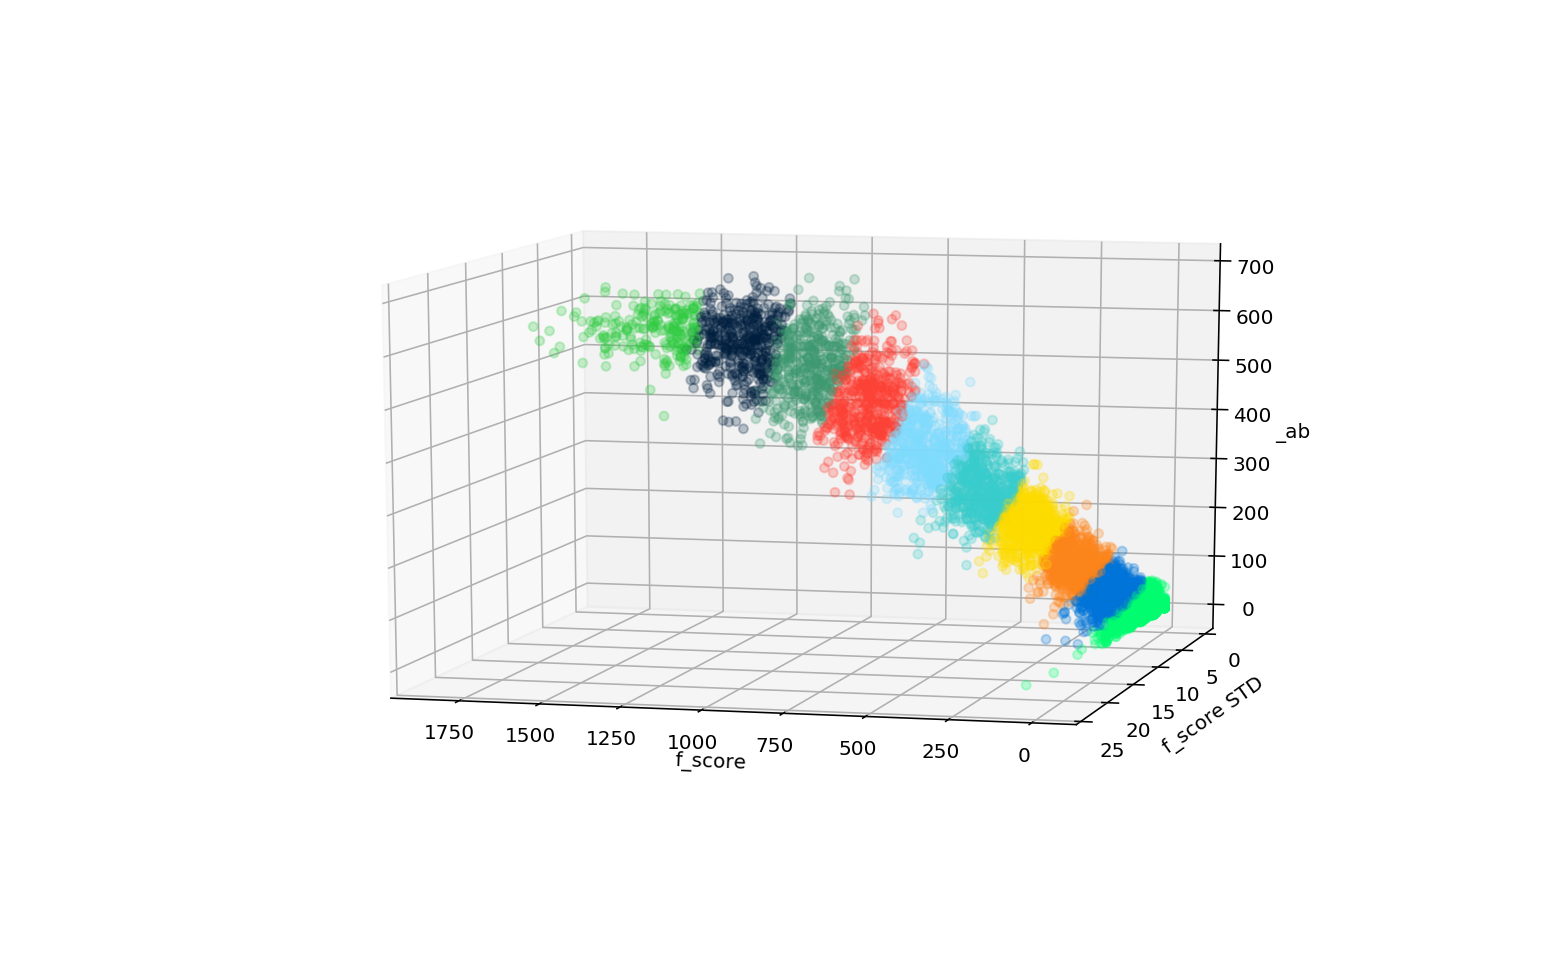

Text(0.5,0,'_ab')

In [384]:
plot_x = 'f_score'
plot_y = 'f_score STD'
plot_y2 = '_ab'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[plot_x],
           X[plot_y],
           X[plot_y2],
           c=X['cluster_color'],
           alpha=.25)

ax.set_xlabel(plot_x)
ax.set_ylabel(plot_y)
ax.set_zlabel(plot_y2)